<a href="https://colab.research.google.com/github/davidYichengWei/APS360-Project/blob/main/APS360_Project_Group_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our APS360 Project.

Goals:
1. Data processing: put images into two folders, one containing images with mask, the other containing images without mask. Only use faces that have pictures of masked face with a resolution of at least 100*100 pixels. Use resize to adjust to 224*224 pixels

2. Primary model: PDSN model, using ResNet50 as pretrained model for the CNN part

3. Baseline model: 

Data Processing:

1.   resize to 224x224
2.   split into masked and no-mask folders
3.   get mask and nomask loaders
4. 
5.   






Mar 25th meeting

Justin: data processing, try mask generator, Mar 28th
Yicheng, Bill: change model structures, Mar 2nd
Helen: tune hyparameters, Mar 2nd

# Imports

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data processing

In [ ]:
# The code was run on local computer
# resize all the images to 224x224 format
import os
from PIL import Image
import shutil
desiredSize = (224, 224)

nomaskDir = 'self-built-masked-face-recognition-dataset/AFDB_face_dataset'
maskDir = 'self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset'

#'self-built-masked-face-recognition-dataset/AFDB_face_dataset/perspon
nomaskPerson = os.listdir(nomaskDir)
nomaskDirPerson = [os.path.join(nomaskDir, person) for person in nomaskPerson]
maskPerson = os.listdir(maskDir)
maskDirPerson = [os.path.join(maskDir, person) for person in maskPerson]

# resize all pics to 224x224
totalNum = 0
for personFolder in nomaskDirPerson:
    for image in os.listdir(personFolder):
        imageFullPath = os.path.join(personFolder, image)
        print(imageFullPath)
        im = Image.open(imageFullPath)
        resized_im = im.resize(desiredSize)
        resized_im.save(imageFullPath)
        totalNum+=1


for personFolder in maskDirByPerson:
    for image in os.listdir(personFolder):
        imageFullPath = os.path.join(personFolder, image)
        print(imageFullPath)
        im = Image.open(imageFullPath)
        resized_im = im.resize(desiredSize)
        resized_im.save(imageFullPath)
        
        totalNum+=1
print(totalNum)        
## 92671


# remove empty folders
emptyPersonName = []
for personFolder in nomaskDirPerson:
    allImage = os.listdir(personFolder)
    if len(allImage) == 0:
        emptyPerson.append(personFolder)
        totalEmpty += 1

for personFolder in maskDirPerson:
    allImage = os.listdir(personFolder)
    if len(allImage) == 0:
        emptyPerson.append(personFolder)
        totalEmpty += 1

personName = []
for entry in emptyPerson:
    parts = entry.split('/')
    name = parts[len(parts)-1]
    personName.append(name)

for name in personName:
    shutil.rmtree(os.path.join(maskDir, name))
    shutil.rmtree(os.path.join(nomaskDir, name))

# remove mismatched folders
mismatch = []
for name in nomaskDirPerson:
    if name not in maskDirByPerson:
        mismatch.append(name)

for name in maskDirByPerson:
    if name not in nomaskDirPerson:
        mismatch.append(name)

# remove repetitive entries
mismatch = list(dict.fromkeys(mismatch))
mismatchFullpath = []
for mis in mismatch:
    for dir in nomaskFullPathByPerson:
        if mis in dir:
            mismatchFullpath.append(dir)
    
    for dir in maskFullPathByPerson:
        if mis in dir:
            mismatchFullpath.append(dir)

for entry in mismatchFullpath:
    shutil.rmtree(entry)

# Get pair loader function that should be run:

In [ ]:
maskRootAddr = '/content/drive/My Drive/Colab Notebooks/pair-dataset/mask/'
nomaskRootAddr = '/content/drive/My Drive/Colab Notebooks/pair-dataset/nomask/'

In [ ]:
# function to create data loader that gives a pair of image to train our FDM network
""" note maskRootAddr and nomaskRootAddr must be the pair folders """
""" 
    when split is set to True, this functions returns trainLoader, valLoader, testLoader
    else only a single loader is returned
"""
""" usage of this loader is:
      loader = getPairLoder(blah blah blah)
      for i, data in enumerate(loader):
          # i is not used
          # data[0][j] is [maskImage, nomaskImage], where j is 0~batchSize
          # data[1] is 1d tensor of labels of size batchSize
"""
def getPairLoader(maskRootAddr, nomaskRootAddr, batchSize=32, split=True):
    allmaskImages = datasets.ImageFolder(root=maskRootAddr, transform=transforms.ToTensor())
    allnomaskImages = datasets.ImageFolder(root=nomaskRootAddr, transform=transforms.ToTensor())

    maskClassStartInd = []
    maskClassStartInd.append(0)
    for i in range(len(allmaskImages)):
        if i+1 == len(allmaskImages): break
        if allmaskImages[i][1] != allmaskImages[i+1][1]:
            maskClassStartInd.append(i+1)

    nomaskClassStartInd = [] 
    nomaskClassStartInd.append(0)
    for i in range(len(allnomaskImages)):
        if i+1 == len(allnomaskImages): break
        if allnomaskImages[i][1] != allnomaskImages[i+1][1]:
            nomaskClassStartInd.append(i+1)

    allPairs = []
    nomaskInd = 0
    for i in range(len(maskClassStartInd)):
        maskInd = maskClassStartInd[i]
        nomaskInd = nomaskClassStartInd[i]
        for ind in range(5):
            maskImage = allmaskImages[maskInd+ind][0]
            nomaskImage = allnomaskImages[nomaskInd+ind][0]
            pair = [maskImage, nomaskImage]
            allPairs.append([pair, i])
    totalPair = len(allPairs)
    allIndices = list(range(totalPair))
    np.random.shuffle(allIndices)
    if split==True:
        split1 = int(totalPair*0.6)
        split2 = int(totalPair*0.8)
        trainSampler = SubsetRandomSampler(allIndices[:split1])
        valSampler = SubsetRandomSampler(allIndices[split1:split2])
        testSampler = SubsetRandomSampler(allIndices[split2:])
        trainLoader = torch.utils.data.DataLoader(allPairs, batch_size=batchSize, sampler=trainSampler)
        valLoader = torch.utils.data.DataLoader(allPairs, batch_size=batchSize, sampler=valSampler)
        testLoader = torch.utils.data.DataLoader(allPairs, batch_size=batchSize, sampler=testSampler)
        return trainLoader, valLoader, testLoader
    else:
        sampler = SubsetRandomSampler(allIndices)
        return torch.utils.data.DataLoader(allPairs, batch_size=batchSize, sampler=sampler)


In [ ]:
train_pair_loader, valid_pair_loader, test_pair_loader = getPairLoader(maskRootAddr, nomaskRootAddr, 32, True)

In [ ]:
# Check size of inputs
for i, data in enumerate(train_pair_loader):
      # Get the inputs
      inputs, labels = data
      x = inputs[1] # 1 means no mask
      print(x.shape)
      # x = x.permute(1, 2, 0)      # move the channel dimension to the end to plot
      # plt.imshow(x)

In [ ]:
# get loaders
def getLoader(rootAddr, batchSize=32):
    allImages = datasets.ImageFolder(root=maskAddr, transform=transforms.ToTensor())
    imgLen = len(allImages)
    print("There are a total of {} images".format(imgLen))
    allIndices = list(range(imgLen))
    np.random.shuffle(allIndices)
    split1 = int(0.6*imgLen)
    split2 = int(0.8*imgLen)
    trainInd = allIndices[ : split1]
    valInd = allIndices[split1:split2]
    testInd = allIndices[split2: ]
    trainSampler = SubsetRandomSampler(trainInd)
    valSampler = SubsetRandomSampler(valInd)
    testSampler = SubsetRandomSampler(testInd)

    trainLoader = torch.utils.data.DataLoader(allImages, batch_size=batchSize, sampler=trainSampler)
    valLoader = torch.utils.data.DataLoader(allImages, batch_size=batchSize, sampler=valSampler)
    testLoader = torch.utils.data.DataLoader(allImages, batch_size=batchSize, sampler=testSampler)
    
    return trainLoader, valLoader, testLoader


In [ ]:
## Loaders update March 30

In [ ]:
"""
    inputs:
        maskRootAddr & nomaskRootAddr & batchSize are as before and self-explanatory

        numPeople is the number of people we will use in our dataset
        
        *Note pair loader uses the last numPeople classes, and ANN loader uses the first numPeople classes
         So need to make sure they dont overlap when calling these 2 functions
    outputs:
        return training, validation, and test loaders if wantTest is set to True
        return training and validation if wantTest is False

"""
""" 
    usage:
    
    for i, data in enumerate(trainLoader):
        print(len(data[0]))
        # 2
        print(data[0][0].shape) # this is the no mask images
        # torch.Size([32, 3, 224, 224])
        print(data[0][1].shape) # this is the masked images
        # torch.Size([32, 3, 224, 224])
        print(data[1].shape)    # this is the labels
        # torch.Size([32])
        break
"""
def getNewPairLoader(maskRootAddr, nomaskRootAddr, batchSize=32, wantTest=False, numPeople=20):
    # totalClassNum = len(os.listdir(maskRootAddr))
    totalClassNum = 173
    wantClass = totalClassNum-numPeople
    
    allmaskImages = datasets.ImageFolder(root=maskRootAddr, transform=transforms.ToTensor())
    # get index of the first occurence of our desired class
    wantmaskInd = wantnomaskInd = 0
    for i in range(len(allmaskImages)):
        if allmaskImages[1] == wantClass:
            wantmaskInd = i
            break
    #allmaskImages = allmaskImages[wantmaskInd:]
    
    allnomaskImages = datasets.ImageFolder(root=nomaskRootAddr, transform=transforms.ToTensor())
    for i in range(len(allnomaskImages)):
        if allmaskImages[1] == wantClass:
            wantnomaskInd = i
            break
    #allnomaskImages = allnomaskImages[wantnomaskInd:]


    allClasses = range(wantClass, totalClassNum)
    # we want only training and validation set
    if wantTest == False:
        train_pair_list, val_pair_list = [], []
        for clas in range(numPeople):
            maskEndInd = nomaskEndInd = 0
            for i in range(wantmaskInd, len(allmaskImages)):
                if i+1 != len(allmaskImages):
                    if allmaskImages[i][1]!=allmaskImages[i+1][1]:
                        maskEndInd = i+1
                        break
                else:
                    maskEndInd = -1
                    break
            classmaskImages = []        
            for i in range(wantmaskInd, maskEndInd if maskEndInd!=-1 else len(allmaskImages)):
                classmaskImages.append(allmaskImages[i])
            wantmaskInd = maskEndInd
            
            
            for i in range(wantnomaskInd, len(allnomaskImages)):
                if i+1 != len(allnomaskImages):                
                    if allnomaskImages[i][1]!=allnomaskImages[i+1][1]:
                        nomaskEndInd = i+1
                        break
                else:
                    nomaskEndInd = -1
                    break
            classnomaskImages = []
            for i in range(wantnomaskInd, nomaskEndInd if nomaskEndInd!=-1 else len(allnomaskImages)):
                classnomaskImages.append(allnomaskImages[i])
            wantnomaskInd = nomaskEndInd

            # next, pair up 
            mask_train = classmaskImages[:int(len(classmaskImages)*0.7)]
            mask_val = classmaskImages[int(len(classmaskImages)*0.7):]
            
            for i in range(200):
                int1 = np.random.randint(0, len(classnomaskImages)-1)
                int2 = np.random.randint(0, len(mask_train)-1)
                train_pair_list.append(([classnomaskImages[int1][0], mask_train[int2][0]], mask_train[int2][1]))

            for i in range(80):
                int1 = np.random.randint(0, len(classnomaskImages)-1)
                int2 = np.random.randint(0, len(mask_val)-1)
                val_pair_list.append(([classnomaskImages[int1][0], mask_val[int2][0]], mask_val[int2][1]))
        
        trainInd = range(len(train_pair_list))
        valInd = range(len(val_pair_list))

        trainSampler = SubsetRandomSampler(trainInd)
        valSampler = SubsetRandomSampler(valInd)
        trainLoader = torch.utils.data.DataLoader(train_pair_list, batch_size=batchSize, sampler=trainSampler)
        valLoader = torch.utils.data.DataLoader(val_pair_list, batch_size=batchSize, sampler=valSampler)
        return trainLoader, valLoader

    # we want training validation and test set
    else:
        train_pair_list, val_pair_list, test_pair_list = [], [], []
        
        for clas in range(numPeople):
            maskEndInd = nomaskEndInd = 0
            for i in range(wantmaskInd, len(allmaskImages)):
                if i+1 != len(allmaskImages):                
                    if allmaskImages[i][1]!=allmaskImages[i+1][1]:
                        maskEndInd = i+1
                        break
                else:
                    maskEndInd = -1
                    break
            classmaskImages = []        
            for i in range(wantmaskInd, maskEndInd if maskEndInd!=-1 else len(allmaskImages)):
                classmaskImages.append(allmaskImages[i])
            wantmaskInd = maskEndInd
            
            
            for i in range(wantnomaskInd, len(allnomaskImages)):
                if i+1 != len(allnomaskImages):                
                    if allnomaskImages[i][1]!=allnomaskImages[i+1][1]:
                        nomaskEndInd = i+1
                        break
                else:
                    nomaskEndInd = -1
                    break
            classnomaskImages = []
            for i in range(wantnomaskInd, nomaskEndInd if nomaskEndInd!=-1 else len(allnomaskImages)):
                classnomaskImages.append(allnomaskImages[i])
            wantnomaskInd = nomaskEndInd

            # next, pair up 
            mask_train = classmaskImages[ :int(len(classmaskImages)*0.6)]
            mask_val = classmaskImages[int(len(classmaskImages)*0.6):int(len(classmaskImages)*0.8)]
            mask_test = classmaskImages[int(len(classmaskImages)*0.8):]
            
            for i in range(200):
                int1 = np.random.randint(0, len(classnomaskImages)-1)
                int2 = np.random.randint(0, len(mask_train)-1)
                train_pair_list.append(([classnomaskImages[int1][0], mask_train[int2][0]], mask_train[int2][1]))

            for i in range(80):
                int1 = np.random.randint(0, len(classnomaskImages)-1)
                int2 = np.random.randint(0, len(mask_val)-1)
                val_pair_list.append(([classnomaskImages[int1][0], mask_val[int2][0]], mask_val[int2][1]))
            for i in range(80):
                int1 = np.random.randint(0, len(classnomaskImages)-1)
                int2 = np.random.randint(0, len(mask_test)-1)
                test_pair_list.append(([classnomaskImages[int1][0], mask_test[int2][0]], mask_val[int2][1]))

        trainInd = range(len(train_pair_list))
        valInd = range(len(val_pair_list))
        testInd = range(len(test_pair_list))
        trainSampler = SubsetRandomSampler(trainInd)
        valSampler = SubsetRandomSampler(valInd)
        testSampler = SubsetRandomSampler(testInd)
        trainLoader = torch.utils.data.DataLoader(train_pair_list, batch_size=batchSize, sampler=trainSampler)
        valLoader = torch.utils.data.DataLoader(val_pair_list, batch_size=batchSize, sampler=valSampler)
        testLoader = torch.utils.data.DataLoader(test_pair_list, batch_size=batchSize, sampler=valSampler)
        return trainLoader, valLoader, testLoader

# Current data_loader function

In [3]:
def getNewOneToOnePairLoader(maskRootAddr, nomaskRootAddr, batchSize=32, numPeople=20):
    totalClassNum = 173
    wantClass = totalClassNum-numPeople
    
    allmaskImages = datasets.ImageFolder(root=maskRootAddr, transform=transforms.ToTensor())
    # get index of the first occurence of our desired class
    wantmaskInd = wantnomaskInd = 0
    for i in range(len(allmaskImages)):
        if allmaskImages[1] == wantClass:
            wantmaskInd = i
            break
            
    allnomaskImages = datasets.ImageFolder(root=nomaskRootAddr, transform=transforms.ToTensor())
    for i in range(len(allnomaskImages)):
        if allmaskImages[1] == wantClass:
            wantnomaskInd = i
            break
            
    train_pair_list, val_pair_list, test_pair_list = [], [], []
    
    for clas in range(numPeople):
        maskEndInd = nomaskEndInd = 0
        for i in range(wantmaskInd, len(allmaskImages)):
            if i+1 != len(allmaskImages):                
                if allmaskImages[i][1]!=allmaskImages[i+1][1]:
                    maskEndInd = i+1
                    break
            else:
                maskEndInd = -1
                break
        classmaskImages = []        
        for i in range(wantmaskInd, maskEndInd if maskEndInd!=-1 else len(allmaskImages)):
            classmaskImages.append(allmaskImages[i])
        wantmaskInd = maskEndInd
        
        
        for i in range(wantnomaskInd, len(allnomaskImages)):
            if i+1 != len(allnomaskImages):                
                if allnomaskImages[i][1]!=allnomaskImages[i+1][1]:
                    nomaskEndInd = i+1
                    break
            else:
                nomaskEndInd = -1
                break
        classnomaskImages = []
        for i in range(wantnomaskInd, nomaskEndInd if nomaskEndInd!=-1 else len(allnomaskImages)):
            classnomaskImages.append(allnomaskImages[i])
        wantnomaskInd = nomaskEndInd

        # next, pair up
        i = 0 
        lenMaskImg = len(classnomaskImages)
        label = classnomaskImages[0][1]
        while i<100:
            train_pair_list.append(([classnomaskImages[i%lenMaskImg][0], classmaskImages[i][0]], label))
            i+=1
        while i<130:
            test_pair_list.append(([classnomaskImages[i%lenMaskImg][0], classmaskImages[i][0]], label))
            i+=1
        while i<160:
            val_pair_list.append(([classnomaskImages[i%lenMaskImg][0], classmaskImages[i][0]], label))
            i+=1
            
    trainInd = list(range(len(train_pair_list)))
    np.random.shuffle(trainInd)
    valInd = list(range(len(val_pair_list)))
    np.random.shuffle(valInd)
    testInd = list(range(len(test_pair_list)))
    np.random.shuffle(testInd)
    trainSampler = SubsetRandomSampler(trainInd)
    valSampler = SubsetRandomSampler(valInd)
    testSampler = SubsetRandomSampler(testInd)
    trainLoader = torch.utils.data.DataLoader(train_pair_list, batch_size=batchSize, sampler=trainSampler)
    valLoader = torch.utils.data.DataLoader(val_pair_list, batch_size=batchSize, sampler=valSampler)
    testLoader = torch.utils.data.DataLoader(test_pair_list, batch_size=batchSize, sampler=valSampler)
    return trainLoader, valLoader, testLoader


In [ ]:
def getNewTrainANNLoader(maskAddr, nomaskAddr, batchsize=32, numPeople=20):

    allnomaskImages = datasets.ImageFolder(root=nomaskAddr, transform=transforms.ToTensor())
    wantInd = 0
    for i in range(len(allnomaskImages)):
        if allnomaskImages[i][1]==numPeople:
            wantInd = i
            break
            
    trainInd = list(range(wantInd))
    np.random.shuffle(trainInd)
    trainSampler = SubsetRandomSampler(trainInd)
    trainLoader = torch.utils.data.DataLoader(allnomaskImages, batch_size=batchsize, sampler=trainSampler)


    allmaskImages = datasets.ImageFolder(root=maskAddr, transform=transforms.ToTensor())
    for i in range(len(allmaskImages)):
        if allmaskImages[1]==numPeople:
            wantInd = i
            break
            
    allInd = list(range(wantInd))
    np.random.shuffle(allInd)
    
    valInd = allInd[:int(0.5*len(allInd))]
    testInd = allInd[int(0.5*len(allInd)):]
    valSampler = SubsetRandomSampler(valInd)
    testSampler = SubsetRandomSampler(testInd)
    
    valLoader = torch.utils.data.DataLoader(allmaskImages, batch_size=batchsize, sampler=valSampler)
    testLoader = torch.utils.data.DataLoader(allmaskImages, batch_size=batchsize, sampler=testSampler)
    return trainLoader, valLoader, testLoader



# Model status saving code

In [ ]:
"""
    Use 
    torch.save(model, PATH)
    to save the parameters to the PATH

    Use 
    model.load(PATH)
    to load parameters from a file
"""
"""
    More info is here:
    https://pytorch.org/tutorials/beginner/saving_loading_models.html
"""

In [ ]:
def get_model_name(name, numPeopleForPair, numPeopleForANN, 
                   batch_size=32, learning_rate=0.01, epoch=15):
    learningRateStr = str(learning_rate).split(".")
    learningRateStr = learningRateStr[0]+learningRateStr[1]
    path = "model_{0}_npP{1}_npA{2}_bs{3}_lr{4}_epoch{5}".format(name, numPeopleForPair, numPeopleForANN,
                                                                     batch_size, learningRateStr, epoch)
    return path

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Model Setup



Setup the model architecture for FDM_Model, which is used to generate the FDM that will be used to "discard" features on faces that will be covered if wearing a mask.

In [4]:
# New Model
# This is the model used to train both FDM and ANN together in one model
# Input: a pair of features derived from pretrained ResNet 50
# Output: 1. fdm: array with the same dimension as the features
#         2. a pair of filtered features
#         3. classification result

class FDMClassifier(nn.Module):
  def __init__(self):
    super(FDMClassifier, self).__init__()
    # 1 * 1 convolution to maintain the size
    self.conv1 = nn.Conv2d(2048, 2048, 1) #in_channels, out_chanels, kernel_size
    # only need a single fc layer
    self.fc1 = nn.Linear(2048, 20)
  
  def forward(self, mask, nomask):
    # generate fdm
    fdm = F.relu(self.conv1(mask - nomask))

    # apply fdm to do filtering
    mask_filtered = mask * fdm
    nomask_filtered = nomask * fdm

    # classification, using masked faces
    x = mask_filtered.view(-1, 2048) # flatten the input
    x = self.fc1(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return (mask_filtered, nomask_filtered, x) 

In [ ]:
# This model is used to do classification of faces.
# Input: features of faces derived from pretrained ResNet 50, after multiplying
# with FDM to discard mask-covered features
# Output: classification result

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    # only need a single fc layer
    self.fc1 = nn.Linear(2048, 20)

  def forward(self, x):
    # Classification
    x = x.view(-1, 2048) # flatten the input
    x = self.fc1(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

In [10]:
 # This is resnet50 pretrained model 
 # Extracts features from last hidden layer of resnet50

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

resnet50 = models.resnet50(pretrained=True)
modules = list(resnet50.children())[:-1]
resnet50 = nn.Sequential(*modules)
# tell the model not to learn or modify the weights / parameters of the model
for p in resnet50.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


# get_accuracy function

In [5]:
# New get_accuracy function
def get_accuracy(pretrained_cnn, fdm_classifier_model, data_loader, batch_size):
  correct = 0
  total = 0

  for i, data in enumerate(data_loader):
    # Get the inputs
    inputs, labels = data
    mask = inputs[0]
    nomask = inputs[1]
    
    if mask.shape[0] != batch_size:
      continue
    

    mask_conv = pretrained_cnn(mask)
    nomask_conv = pretrained_cnn(nomask)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        mask_conv = mask_conv.cuda()
        nomask_conv = nomask_conv.cuda()
        labels = labels.cuda()
    #############################################

    mask_filtered, nomask_filtered, output = fdm_classifier_model(mask_conv, nomask_conv)

    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += mask.shape[0]

  return correct / total


In [ ]:
# Baseline get_accuracy function
def get_accuracy_baseline(pretrained_cnn, classifier_model, data_loader, batch_size):
  correct = 0
  total = 0

  for i, data in enumerate(data_loader):
    # Get the inputs
    inputs, labels = data
    mask = inputs[0]
    
    if mask.shape[0] != batch_size:
      continue
    

    mask_conv = pretrained_cnn(mask)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        mask_conv = mask_conv.cuda()
        labels = labels.cuda()
    #############################################

    output = classifier_model(mask_conv)

    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += mask.shape[0]

  return correct / total


In [ ]:
# get_accuracy function for the second stage of training: fix FDM and train ANN
def get_accuracy_classifier(pretrained_cnn, fdm, classifier_model, data_loader, batch_size):
  correct = 0
  total = 0

  for i, data in enumerate(data_loader):
    # Get the inputs
    inputs, labels = data
    
    if inputs.shape[0] != batch_size:
      continue
    
    conv_features = pretrained_cnn(inputs)
    filtered_features = conv_features * fdm

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        filtered_features = filtered_features.cuda()
        labels = labels.cuda()
    #############################################

    output = classifier_model(filtered_features)

    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += inputs.shape[0]

  return correct / total

# train function

In [8]:
# Train function 1: train FDM + ANN
def train(pretrained_cnn, fdm_classifier_model, train_pair_loader, valid_pair_loader, batch_size, num_epochs = 5, learning_rate=1e-3):

  torch.manual_seed(1) # set the random seed

  criterionFDM = nn.MSELoss() # mean square error loss to train FDM
  criterionClassifier = nn.CrossEntropyLoss() # CE loss for classification of multiple classes
  optimizer = torch.optim.Adam(fdm_classifier_model.parameters(), lr = learning_rate) # use Adam optimizer

  epochs, every_iteration, fdm_losses, classifier_losses, losses, train_acc, valid_acc = [], [], [], [], [], [], []
  iter = 0
  for epoch in range(num_epochs):
    print("Epoch", epoch)
    for i, data in enumerate(train_pair_loader):
      iter += 1
      print("batch", i)
      # Get the inputs
      inputs, labels = data
      inputs_mask = inputs[0]
      inputs_nomask = inputs[1]

      # Discard the last batch to make size of fdm consistent
      if inputs_mask.shape[0] != batch_size:
        continue
      

      mask_conv = pretrained_cnn(inputs_mask)
      nomask_conv = pretrained_cnn(inputs_nomask)

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          mask_conv = mask_conv.cuda()
          nomask_conv = nomask_conv.cuda()
          labels = labels.cuda()
      #############################################

      mask_filtered, nomask_filtered, out = fdm_classifier_model(mask_conv, nomask_conv)

      fdm_loss = criterionFDM(mask_filtered, nomask_filtered) # The first loss is contrastive loss

      classifier_loss = criterionClassifier(out, labels)
      print("contrastive loss is", fdm_loss)
      print("classification loss is", classifier_loss)

      every_iteration.append(iter)
      fdm_losses.append(float(fdm_loss))
      classifier_losses.append(float(classifier_loss))

      total_loss = fdm_loss * 1 + classifier_loss
      print("total loss is", total_loss)
      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # get accuracy for every epoch
    train_accuracy = get_accuracy(pretrained_cnn, fdm_classifier_model, train_pair_loader, batch_size)
    valid_accuracy = get_accuracy(pretrained_cnn, fdm_classifier_model, valid_pair_loader, batch_size)
    print("train accuracy is", train_accuracy)
    print("validation accuracy is", valid_accuracy)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
    losses.append(float(total_loss))
    epochs.append(epoch)
    ## Add code here

  # plotting contrastive loss curve
  plt.title("Contrastive Loss Curve")
  plt.plot(every_iteration, fdm_losses, label="Contrastive Loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

  # plotting classification loss curve
  plt.title("Classification Loss Curve")
  plt.plot(every_iteration, classifier_losses, label="Classification Loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

  # plotting overall loss curve
  plt.title("Loss Curve")
  plt.plot(epochs, losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  # plotting accuracy curve
  plt.title("Accuracy Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Train function 1: train FDM + ANN
def trainBaseline(pretrained_cnn, classifier_model, train_pair_loader, valid_pair_loader, batch_size, num_epochs = 5, learning_rate=1e-3):

  torch.manual_seed(1) # set the random seed

  criterion = nn.CrossEntropyLoss() # CE loss for classification of multiple classes
  optimizer = torch.optim.Adam(classifier_model.parameters(), lr = learning_rate) # use Adam optimizer

  epochs, every_iteration, iteration_losses, train_acc, valid_acc = [], [], [], [], []
  iter = 0
 
  for epoch in range(num_epochs):
    print("Epoch", epoch)
    for i, data in enumerate(train_pair_loader):
      iter += 1
      print("batch", i)
      # Get the inputs
      inputs, labels = data
      inputs_mask = inputs[0]
      inputs_nomask = inputs[1]

      # Discard the last batch to make size of fdm consistent
      if inputs_mask.shape[0] != batch_size:
        continue
      

      mask_conv = pretrained_cnn(inputs_mask)

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          mask_conv = mask_conv.cuda()
          labels = labels.cuda()
      #############################################

      out = classifier_model(mask_conv)

      loss = criterion(out, labels)

      print("classification loss is", loss)

      every_iteration.append(iter)
      iteration_losses.append(float(loss))

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # get accuracy for every epoch
    train_accuracy = get_accuracy_baseline(pretrained_cnn, classifier_model, train_pair_loader, batch_size)
    valid_accuracy = get_accuracy_baseline(pretrained_cnn, classifier_model, valid_pair_loader, batch_size)
    print("train accuracy is", train_accuracy)
    print("validation accuracy is", valid_accuracy)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
    epochs.append(epoch)
    ## Add code here


  # plotting every iteration loss curve
  plt.title("Loss Curve")
  plt.plot(every_iteration, iteration_losses, label="Loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

  # plotting accuracy curve
  plt.title("Accuracy Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Train function 2: fix FDM, train ANN only

def trainANN(pretrained_cnn, classifier_model, fdm, train_loader, valid_loader, batch_size, num_epochs = 5, learning_rate=1e-3):

  torch.manual_seed(1) # set the random seed

  criterion = nn.CrossEntropyLoss() # CE loss for classification of multiple classes
  optimizer = torch.optim.Adam(classifier_model.parameters(), lr = learning_rate) # use Adam optimizer

  every_iteration, epochs, losses, train_acc, valid_acc = [], [], [], [], []

  iter = 0
  for epoch in range(num_epochs):
    print("Epoch", epoch)
    for i, data in enumerate(train_loader):
      iter += 1
      print("batch", i)
      # Get the inputs
      inputs, labels = data
      

      # Discard the last batch to make size of fdm consistent
      if inputs.shape[0] != batch_size:
        continue

      # Use unmasked faces to train
      nomask_conv = pretrained_cnn(inputs)

      # Use fixed FDM to discard some features
      nomask_filtered = nomask_conv * fdm

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          nomask_filtered = nomask_filtered.cuda()
          labels = labels.cuda()
      #############################################

      out = classifier_model(nomask_filtered)
      
      loss = criterion(out, labels) # Classification loss

      print("loss is", loss)
      every_iteration.append(iter)
      losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # record for every epoch   
    epochs.append(epoch)
    train_accuracy = get_accuracy_classifier(pretrained_cnn, fdm, classifier_model, train_loader, batch_size)
    valid_accuracy = get_accuracy_classifier(pretrained_cnn, fdm, classifier_model, valid_loader, batch_size)
    print("train accuracy is", train_accuracy)
    print("validation accuracy is", valid_accuracy)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)

  # plotting loss curve
  plt.title("Loss Curve")
  plt.plot(every_iteration, losses, label="Loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

  # plotting accuracy curve
  plt.title("Accuracy Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()



# 1st stage of training: train FDM + ANN, but the purpose is to train FDM

In [7]:
maskRootAddr = '/content/drive/My Drive/Colab Notebooks/new-one2one-pair-dataset/mask/'
nomaskRootAddr = '/content/drive/My Drive/Colab Notebooks/new-one2one-pair-dataset/nomask/'

new_train_pair_loader, new_valid_pair_loader, new_test_pair_loader = getNewOneToOnePairLoader(maskRootAddr, nomaskRootAddr, 128, 20)

In [ ]:
for i, data in enumerate(new_train_pair_loader):
  print(i)
  # Get the inputs
  inputs, labels = data
  mask = inputs[0]
  
  nomask = inputs[1]
  print(labels)
    

CUDA is available!  Training on GPU ...
Epoch 0
batch 0
contrastive loss is tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward>)
classification loss is tensor(2.9995, device='cuda:0', grad_fn=<NllLossBackward>)
total loss is tensor(3.0054, device='cuda:0', grad_fn=<AddBackward0>)
batch 1
contrastive loss is tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward>)
classification loss is tensor(2.8857, device='cuda:0', grad_fn=<NllLossBackward>)
total loss is tensor(2.8922, device='cuda:0', grad_fn=<AddBackward0>)
batch 2
contrastive loss is tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward>)
classification loss is tensor(2.7742, device='cuda:0', grad_fn=<NllLossBackward>)
total loss is tensor(2.7812, device='cuda:0', grad_fn=<AddBackward0>)
batch 3
contrastive loss is tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
classification loss is tensor(2.6669, device='cuda:0', grad_fn=<NllLossBackward>)
total loss is tensor(2.6748, device='cuda:0', grad_fn=<AddBackward

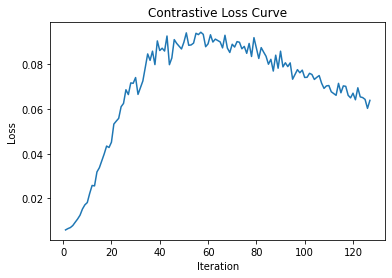

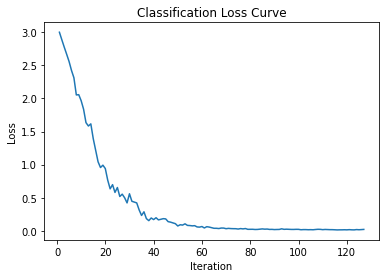

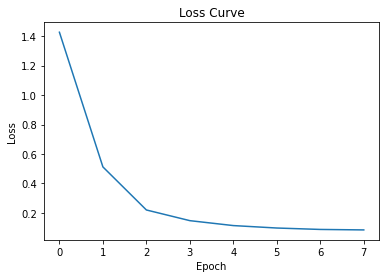

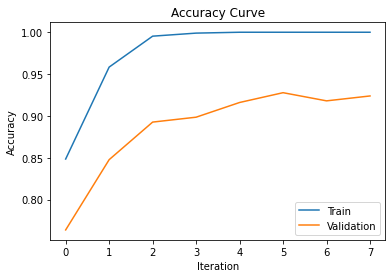

In [11]:
# One click to train

fdm_classifier_model = FDMClassifier()

#Use GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
  fdm_classifier_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(resnet50, fdm_classifier_model, new_train_pair_loader, new_valid_pair_loader, 128, 8, 0.0008)

In [13]:
test_accuracy = get_accuracy(resnet50, fdm_classifier_model, new_test_pair_loader, 128)
print("Test accuracy is", test_accuracy)

Test accuracy is 0.923828125


CUDA is available!  Training on GPU ...
Epoch 0
batch 0
classification loss is tensor(3.0104, device='cuda:0', grad_fn=<NllLossBackward>)
batch 1
classification loss is tensor(3.0856, device='cuda:0', grad_fn=<NllLossBackward>)
batch 2
classification loss is tensor(3.1186, device='cuda:0', grad_fn=<NllLossBackward>)
batch 3
classification loss is tensor(2.9957, device='cuda:0', grad_fn=<NllLossBackward>)
batch 4
classification loss is tensor(2.9403, device='cuda:0', grad_fn=<NllLossBackward>)
batch 5
classification loss is tensor(2.9852, device='cuda:0', grad_fn=<NllLossBackward>)
batch 6
classification loss is tensor(2.9839, device='cuda:0', grad_fn=<NllLossBackward>)
batch 7
classification loss is tensor(2.9227, device='cuda:0', grad_fn=<NllLossBackward>)
batch 8
classification loss is tensor(2.9552, device='cuda:0', grad_fn=<NllLossBackward>)
batch 9
classification loss is tensor(2.8897, device='cuda:0', grad_fn=<NllLossBackward>)
batch 10
classification loss is tensor(2.9316, devic

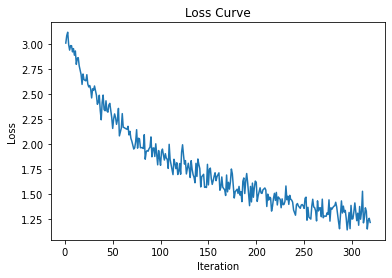

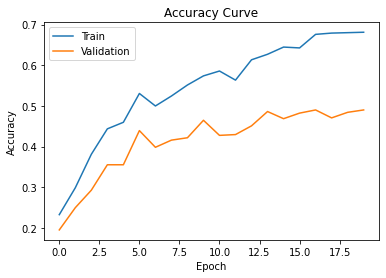

In [ ]:
# Train baseline CNN model
classifier_model = Classifier()

if use_cuda and torch.cuda.is_available():
  classifier_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
trainBaseline(resnet50, classifier_model, new_train_pair_loader, new_valid_pair_loader, 128, 20, 0.0008)

In [ ]:
test_accuracy = get_accuracy_baseline(resnet50, classifier_model, new_test_pair_loader, 128)
print("Baseline model test accuracy is", test_accuracy)

NameError: ignored

# 2nd stage of training: using fixed FDM to train ANN classifier

In [ ]:
train_ann_loader, valid_ann_loader, test_an_loader = getNewTrainANNLoader(maskRootAddr, nomaskRootAddr, 128, 20)

In [ ]:
# Check size of inputs
for imgs, labels in train_ann_loader:
  print("1")
  
  print(imgs.shape)
  # x = x.permute(1, 2, 0)      # move the channel dimension to the end to plot
  # plt.imshow(x)

In [ ]:

classifier_model = Classifier()

#Use GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
  classifier_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
trainANN(resnet50, classifier_model, fdm, train_ann_loader, valid_ann_loader, 128, 7, 0.002)

CUDA is available!  Training on GPU ...
Epoch 0
batch 0
loss is tensor(2.9976, device='cuda:0', grad_fn=<NllLossBackward>)
batch 1
loss is tensor(2.9880, device='cuda:0', grad_fn=<NllLossBackward>)
batch 2
loss is tensor(2.9848, device='cuda:0', grad_fn=<NllLossBackward>)
batch 3
loss is tensor(2.9668, device='cuda:0', grad_fn=<NllLossBackward>)
batch 4
loss is tensor(2.9415, device='cuda:0', grad_fn=<NllLossBackward>)
batch 5
loss is tensor(2.9575, device='cuda:0', grad_fn=<NllLossBackward>)
batch 6
loss is tensor(2.9766, device='cuda:0', grad_fn=<NllLossBackward>)
batch 7
loss is tensor(2.9481, device='cuda:0', grad_fn=<NllLossBackward>)
batch 8
loss is tensor(2.9596, device='cuda:0', grad_fn=<NllLossBackward>)
batch 9
loss is tensor(2.9389, device='cuda:0', grad_fn=<NllLossBackward>)
batch 10
loss is tensor(2.9767, device='cuda:0', grad_fn=<NllLossBackward>)
batch 11
loss is tensor(2.9742, device='cuda:0', grad_fn=<NllLossBackward>)
batch 12
loss is tensor(2.8932, device='cuda:0', g

KeyboardInterrupt: ignored

In [ ]:
def trainANN(pretrained_cnn, classifier_model, fdm, train_loader, valid_loader, batch_size, num_epochs = 5, learning_rate=1e-3):

# Baseline Model


SVM Link: https://colab.research.google.com/drive/1ootPn-Rpa7Xc96RRlHmYdbC9GsC1LIzg?usp=sharing


In [ ]:
maskRootAddr_2 = '/content/drive/My Drive/Colab Notebooks/pair-dataset/mask/'
nomaskRootAddr_2 = '/content/drive/My Drive/Colab Notebooks/pair-dataset/nomask/'

class BaselineCNN(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__() #Input 3*244*244
        self.name="BaselineCNN"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size (5*220*220)
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride (size after pooling 5*110*110)
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size (size 10*106*106, after pooling 10*53*53)
        self.fc1 = nn.Linear(53*53*10, 120) 
        self.fc2 = nn.Linear(120, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def get_accuracy_baseline(model, data_loader):
    #data can be train_loader, val_loader, or small_loader

    correct = 0
    total = 0

    for imgs, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
  
def trainBaseline(model, batch_size = 32, num_epochs=1, learning_rate = 0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations

    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss

        train_acc.append(get_accuracy_baseline(model, baseline_train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_baseline(model, baseline_val_loader))  # compute validation accuracy
        n += 1
        print("Epoch: ", epoch, ", training accuracy: ", train_acc[-1], "validation accuracy: ", val_acc[-1]) 
          
        path = "baseline_model_{0}_lr{1}_epoch{2}".format(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), path)     


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))



In [ ]:
baseline_train_loader, baseline_val_loader, baseline_test_loader = getNewTrainANNLoader(maskAddr, nomaskAddr, batchsize=32, numPeople=20):
baselineModel = BaselineCNN()
trainBaseline(baselineModel, batch_size = 32, num_epochs=10)